In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("./housing.csv")

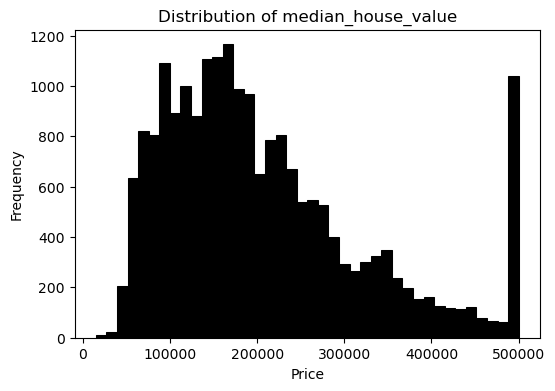

In [3]:
# EDA 

plt.figure(figsize=(6, 4))

sns.histplot(df.median_house_value, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of median_house_value')

plt.show()

In [4]:
selected_df = df[(df['ocean_proximity']=='<1H OCEAN')|(df['ocean_proximity']=='INLAND')][['latitude',
                                                                            'longitude',
                                                                            'housing_median_age',
                                                                            'total_rooms',
                                                                            'total_bedrooms',
                                                                            'population',
                                                                            'households',
                                                                            'median_income',
                                                                            'median_house_value']]

In [5]:
missing_df = selected_df.isna().sum()
print(missing_df)
print("Q1. feature with missing value: ", missing_df[missing_df>0].index.to_list())

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64
Q1. feature with missing value:  ['total_bedrooms']


In [6]:
print("Q2. median for variable 'population': ", selected_df['population'].median())

Q2. median for variable 'population':  1195.0


In [7]:
np.random.seed(42)

n = len(selected_df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = selected_df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [8]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

### Linear Regression

In [9]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

### Baseline solution

In [10]:
base = ['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

In [11]:
def prepare_X(df, fillna_val):
    df_num = df[base]
    df_num = df_num.fillna(fillna_val)
    X = df_num.values
    return X

In [12]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [13]:
# fillna with 0 
X_train = prepare_X(df_train, 0)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, 0)
y_pred = w_0 + X_val.dot(w)
print('validation', round(rmse(y_val, y_pred),2))

validation 0.34


In [14]:
# fillna with average total_bedrooms
X_train = prepare_X(df_train, df_train['total_bedrooms'].mean())
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, df_train['total_bedrooms'].mean())
y_pred = w_0 + X_val.dot(w)
print('validation', round(rmse(y_val, y_pred),2))

validation 0.34


In [15]:
print("Q3. Both are equally good")

Q3. Both are equally good


### Regularization

In [16]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [17]:
X_train = prepare_X(df_train, 0)

In [18]:
r_rmse_vals = {}
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val, 0)
    y_pred = w_0 + X_val.dot(w)
    
    print("r = ", r)
    print('validation: ', rmse(y_val, y_pred), ', validation to 2 decimal digits: ', round(rmse(y_val, y_pred),2))
    
    r_rmse_vals[r] = rmse(y_val, y_pred)

r =  0
validation:  0.3408479034176266 , validation to 2 decimal digits:  0.34
r =  1e-06
validation:  0.3408479061831008 , validation to 2 decimal digits:  0.34
r =  0.0001
validation:  0.3408481800530155 , validation to 2 decimal digits:  0.34
r =  0.001
validation:  0.34085069219092584 , validation to 2 decimal digits:  0.34
r =  0.01
validation:  0.3408779300484923 , validation to 2 decimal digits:  0.34
r =  0.1
validation:  0.34128620419919536 , validation to 2 decimal digits:  0.34
r =  1
validation:  0.3448958327642612 , validation to 2 decimal digits:  0.34
r =  5
validation:  0.3477398070484778 , validation to 2 decimal digits:  0.35
r =  10
validation:  0.3483149833518236 , validation to 2 decimal digits:  0.35


In [19]:
print("Q4:", min(r_rmse_vals, key=r_rmse_vals.get), " has the smallest rmse")

Q4: 0  has the smallest rmse


In [20]:
def process_with_seed_val(seed_val): 
    np.random.seed(seed_val)

    n = len(selected_df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = selected_df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()


    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_train = prepare_X(df_train, 0)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, 0)
    y_pred = w_0 + X_val.dot(w)
    return rmse(y_val, y_pred)
    
    

In [21]:
rmse_val_score = []
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    rmse_val_score.append(process_with_seed_val(i))
    
print("Q5 std val: ", round(np.array(rmse_val_score).std(),3))

Q5 std val:  0.005


In [22]:
np.random.seed(9)

n = len(selected_df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = selected_df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()


y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

X_train = prepare_X(pd.concat([df_train, df_val]), 0)
w_0, w = train_linear_regression_reg(X_train, np.append(y_train, y_val), r=0.001)


X_test = prepare_X(df_test, 0)
y_pred = w_0 + X_test.dot(w)

print('Q6. RMSE on test: ', round(rmse(y_test, y_pred),2))

Q6. RMSE on test:  0.33
